<a href="https://colab.research.google.com/github/ludaladila/Explainable-Techniques-II/blob/main/XAI_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
###
### Yiqing Liu


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1n5bCZ1OXTUkwUxKDnyyipqZDKMnauivO#scrollTo=ZLaQdHnhjt3m)

Introduction: This project uses 'Default of Credit Card Clients' dataset to predict whether a customer will default in the next month.
We apply machine learning models and interpretability techniques including PDP, ICE, and ALE to analyze.

Dataset:[Default of Credit Card Clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

This dataset comes from a Taiwanese bank and is used to predict whether a credit card client will default in the next month. It contains 30,000 records with 25 features, including demographic information, credit limit, repayment status for the past six months, bill amounts, and payment amounts. The target variable is default payment next month, which indicates whether the client defaulted in the following month.



In [62]:
!pip install ucimlrepo PyALE

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
import matplotlib.pyplot as plt



#1. Import the data

In [46]:
# No AI tools were used for this assignment”
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

# 2. Data preprocessing

In [48]:
df = df.drop('ID', axis=1)

In [49]:
df.isnull().any()

,0
LIMIT_BAL,False
SEX,False
EDUCATION,False
MARRIAGE,False
AGE,False
PAY_0,False
PAY_2,False
PAY_3,False
PAY_4,False
PAY_5,False


In [50]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [51]:
print(df.duplicated().sum())


35


In [52]:
df["SEX"].value_counts()


,count
SEX,
2,18112
1,11888


In [53]:
df["EDUCATION"].value_counts()


,count
EDUCATION,
2,14030
1,10585
3,4917
5,280
4,123
6,51
0,14


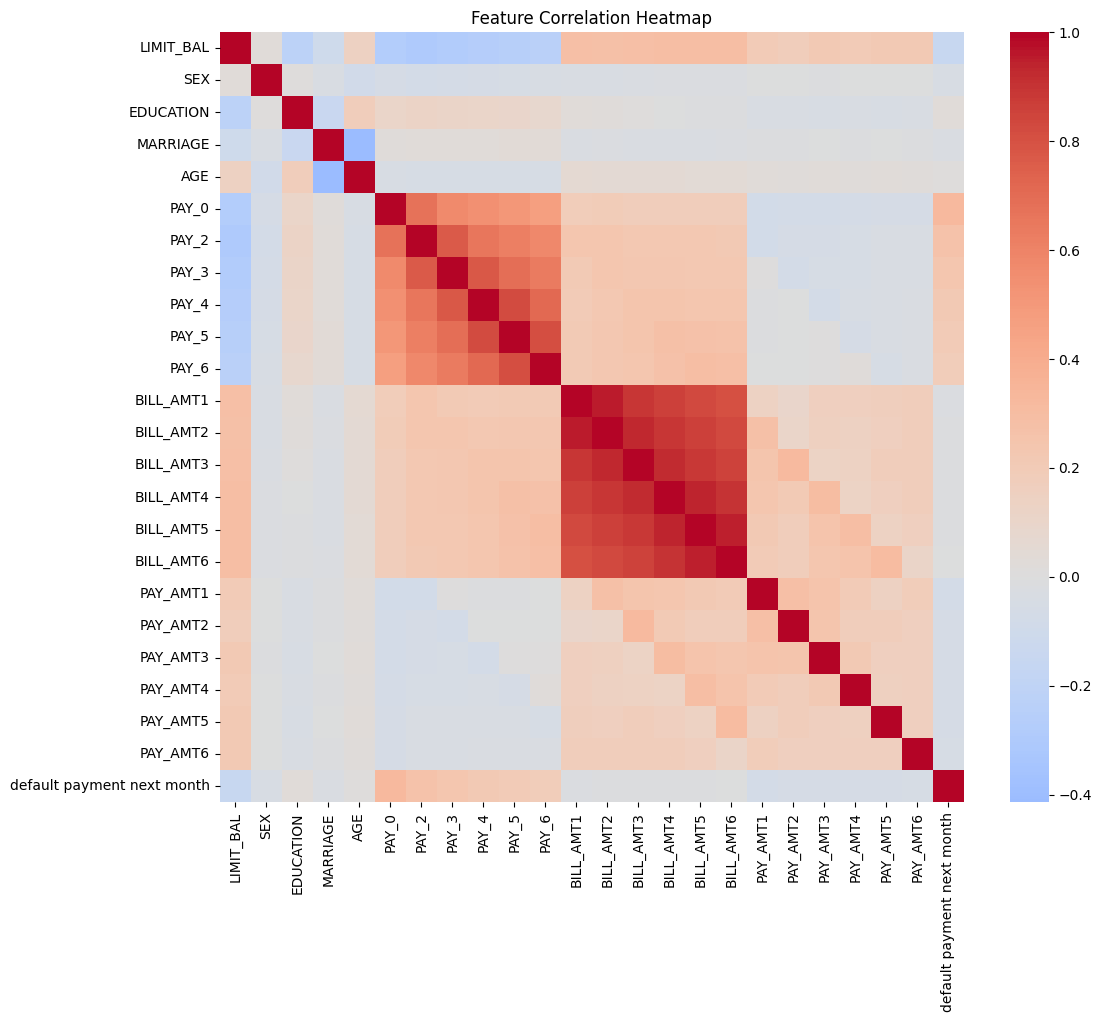

In [54]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### Correlation
1. PAY_0 is highly correlated with default. This indicates that a customer's recent repayment behavior is the most important signal for predicting whether they will default
2. There is a negative correlation between LIMIT_BAL and default. This means that customers with higher credit limits are less likely to default
3. There is a positive correlation between the bill amounts for the six months BILL_AMT1 to BILL_AMT6, suggesting that customers remain relatively consistent.



# 3. Model training

In [55]:
# model training and predition

X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

ROC-AUC: 0.7827891182218614


# 4. PDP/ ICE

### PDP + ICE Plots (1D Single Features)

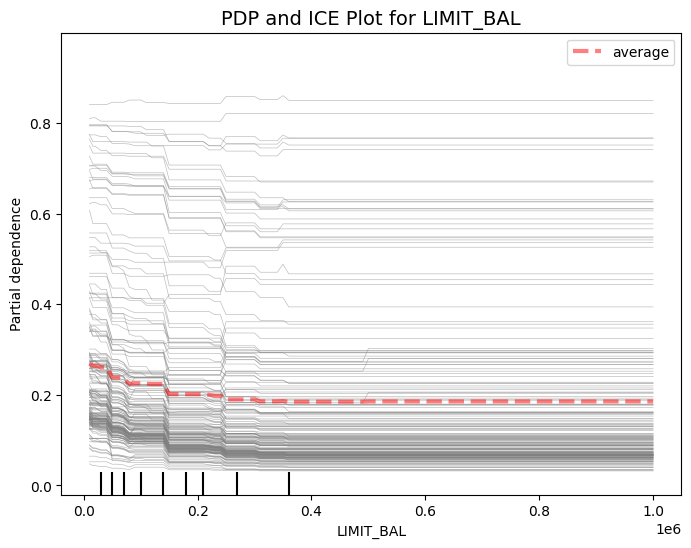

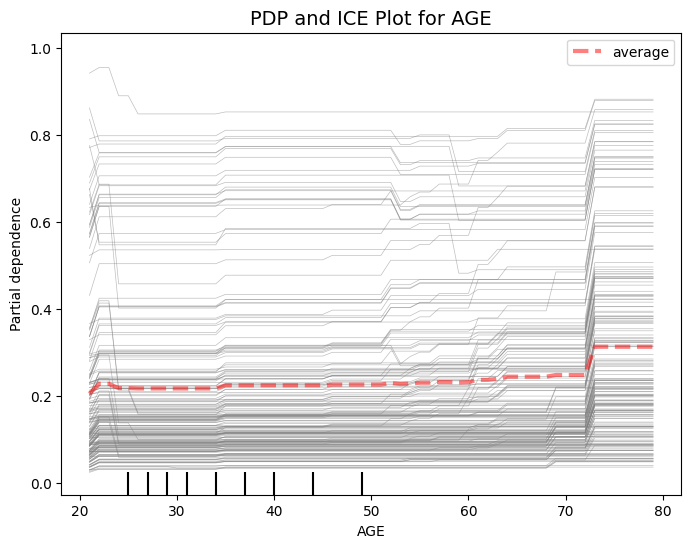

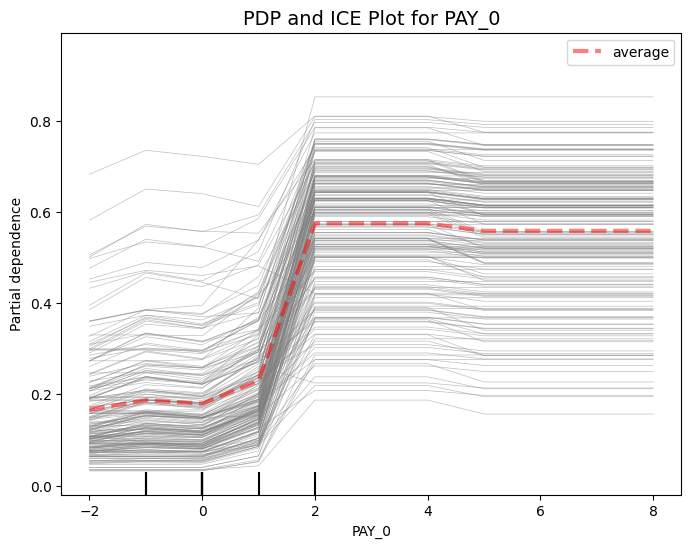

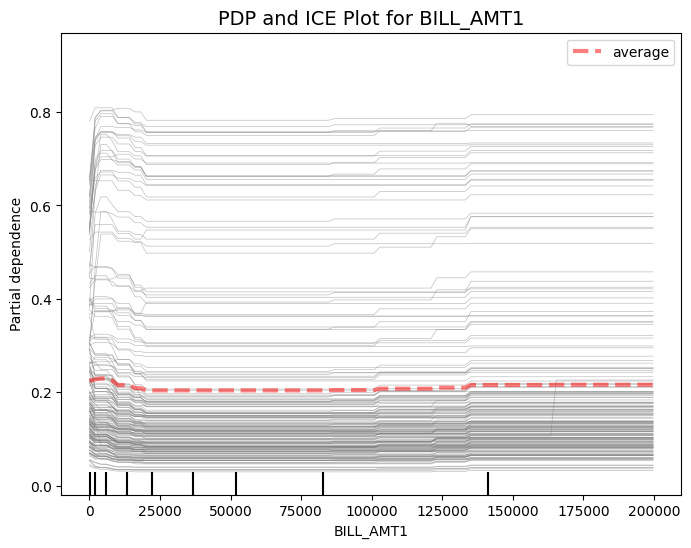

In [79]:
# Generate PDP and ICE  Plots （1D Single Features）
# The following code snippet was generated using gemini 2.5pro on 28/9/25 at 10:21pm.

features_to_analyze = ['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1']

for feature in features_to_analyze:
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use kind='both' to plot PDP and ICE together
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=[feature],
        kind='both',
        subsample=200,
        random_state=42,
        ax=ax,
        line_kw={"color": "gray", "alpha": 0.5, "linewidth": 0.5},
        pd_line_kw={"color": "red", "linewidth": 3}               # Style for PDP line
    )

    ax.set_title(f"PDP and ICE Plot for {feature}", fontsize=14)
    plt.show()


### PDP and ICE  Plots (1D Single Features) Interpretation
PAY_0: The chart shows that once the payment delay reaches two months, the predicted default risk increases from 25% to about 60%. This applies to almost all customers, which shows it is the model's most important basis for its decision.

LIMIT_BAL: From the chart, we can see that the higher the credit limit, the lower the predicted default risk. The average trend and the great majority of individuals follow this pattern, which indicates it is a stable and important predictor.

AGE: On average, age has almost no effect on default risk. However, the chaotic individual curves show that age is not an independent predictive factor.

BILL_AMT1: The average effect of the bill amount is also almost zero.

### 2D PDP

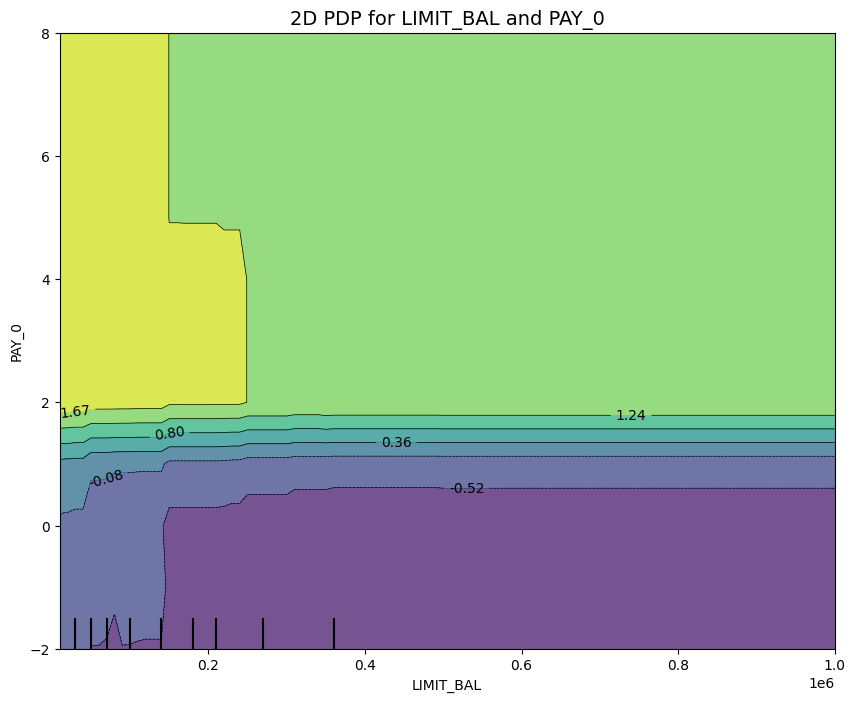

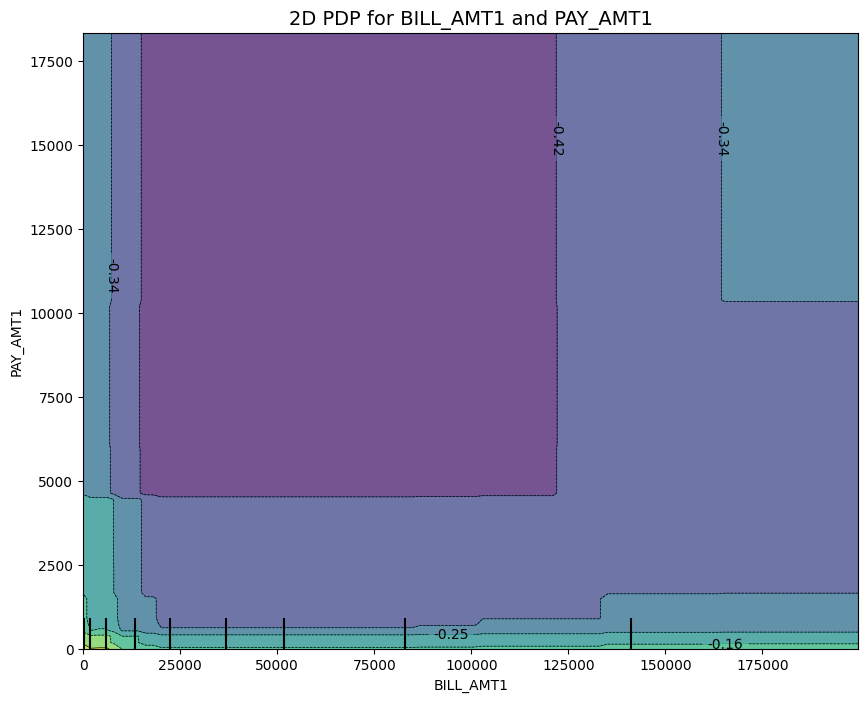

In [73]:
# The following code snippet was generated using gemini 2.5pro on 28/9/25 at 10:21pm.
# Generate PDP Plots （2D Single Features）

pdp_2d_features = [('LIMIT_BAL', 'PAY_0'), ('BILL_AMT1', 'PAY_AMT1')]

for feature_pair in pdp_2d_features:
    fig, ax = plt.subplots(figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=[feature_pair],
        ax=ax
    )
    ax.set_title(f"2D PDP for {feature_pair[0]} and {feature_pair[1]}", fontsize=14)
    plt.show()


### Interpretation
1.  Regardless of the LIMIT_BAL value, for PAY_0, as its value moves upwards, it sharply changes from low risk to high risk. There is a dividing line when PAY_0 is around 2. At this point, no matter how high the customer's credit limit is, the model considers him/her to have an extremely high default risk.

2.  The effect of the credit limit is found to be "conditional". When PAY_0 is less than 2, the effect of LIMIT_BAL is clear. In the chart, from left to right, the color changes from light purple to dark purple, which shows that for customers who pay on time, a higher credit limit means a lower default risk.
3.  when PAY_A is 2 or greater, the contour lines are almost horizontal. This means that for a customer who has already delayed payment for two months, the credit limit has little relationship with the default risk.
4. When the PAY_AMT1 and BILL_ATM1  is very low, the risk is the highest. Then, when PAY_AMT1 > 5000, their default risk is considered to be lower.

# 5. ALE

### ALE Plots (1D)

INFO:PyALE._ALE_generic:Continuous feature detected.


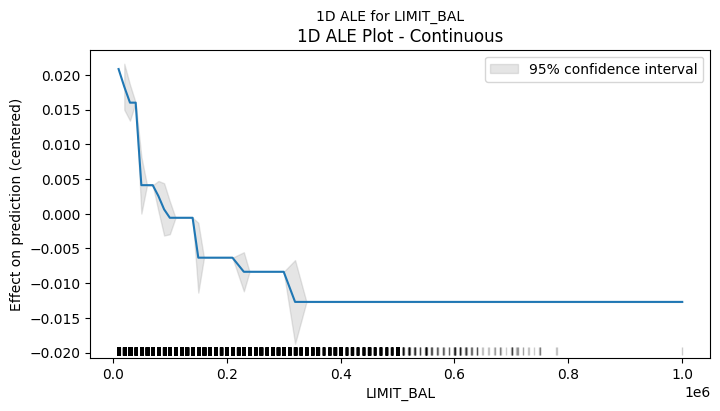

INFO:PyALE._ALE_generic:Discrete feature detected.


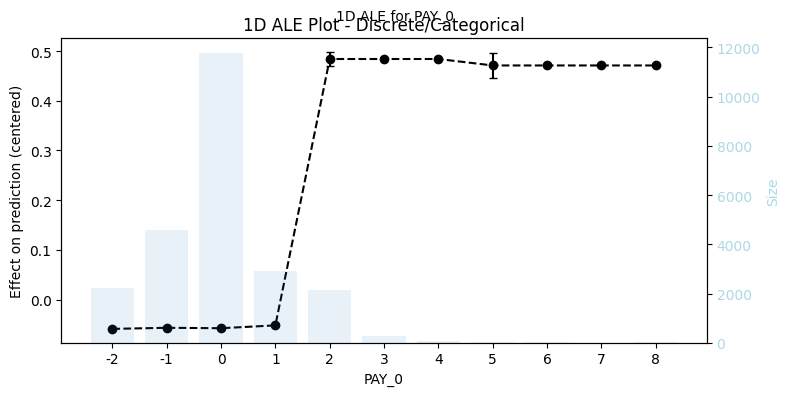

INFO:PyALE._ALE_generic:Continuous feature detected.


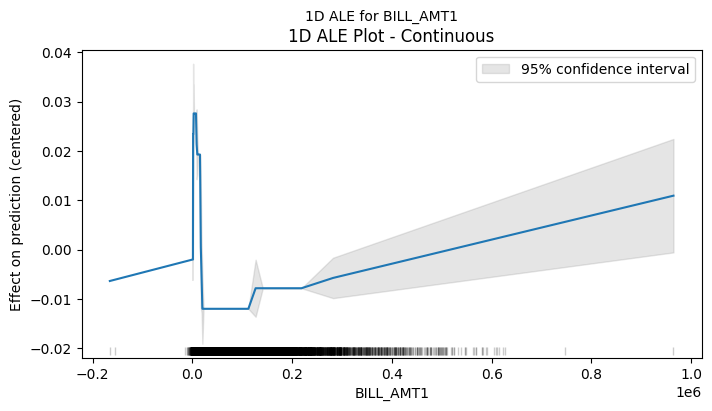

INFO:PyALE._ALE_generic:Continuous feature detected.


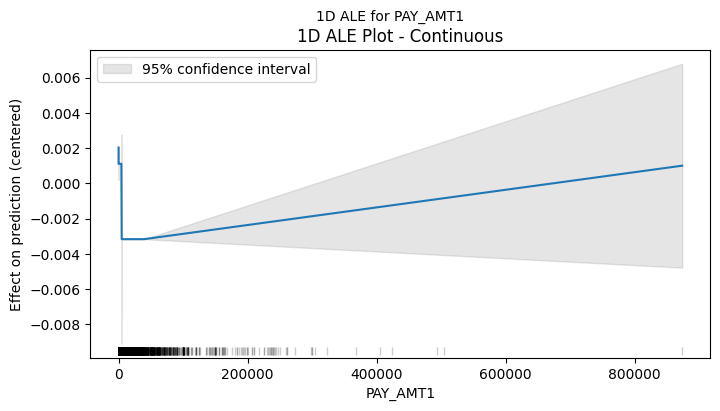

In [77]:
# The following code snippet was generated using gemini 2.5pro on 28/9/25 at 10:40pm.
# ALE Plots (1D)
ale_1d_features = ['LIMIT_BAL', 'PAY_0', 'BILL_AMT1', 'PAY_AMT1']

for feature in ale_1d_features:
    ale(
        X=X_train,
        model=model,
        feature=[feature],
        grid_size=50,
        include_CI=True
    )
    plt.suptitle(f"1D ALE for {feature}", fontsize=10)
    plt.show()


### Interpretation

 1. From the chart, we cna find that teh recent payment status is the most critical feature affecting the prediction. It shows a strong threshold effect, especially when payment is delayed by two months, significantly increasing the model's predicted probability of default.

2. In contrast, credit limit shows a negative monotonic relationship with default risk. A higher limit is a stable indicator of a customer's long-term creditworthiness and is associated with lower predicted risk.

3. The independent effect of short-term transaction features, such as single-month bill amounts and payment amounts, is relatively limited.

Therefore, the model's predictive logic is primarily driven by the customer's long-term creditworthiness and recent severe delinquency, rather than by short-term transaction amounts

### ALE Interaction Plots (2D)

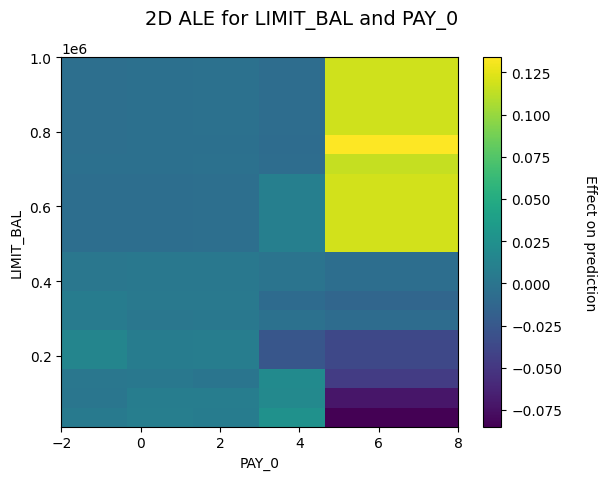

In [78]:
# Generating 2D ALE Interaction Plot
# The following code snippet was generated using gemini 2.5pro on 28/9/25 at 11:03pm.
ale_2d_feature_pair = ['LIMIT_BAL', 'PAY_0']

ale(
    X=X_train,
    model=model,
    feature=ale_2d_feature_pair,
    grid_size=20
)
plt.suptitle(f"2D ALE for {ale_2d_feature_pair[0]} and {ale_2d_feature_pair[1]}", fontsize=14)
plt.show()

### Interpretation
1. We can find when there is no recent delinquency, the credit limit has almost no effect on the chance of default.
2. Once delinquency gets worse, the model raises the default chance clearly. And the higher the limit, the bigger the raise.
4. For people with low limits but severe delinquency, the increase is weaker, and in some areas it even drops a little.
Overall, the default risk is decided by both the level of delinquency and the credit limit, and they clearly interact.

# 6. PDP vs ALE
